In [2]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import numpy as np
import matplotlib.pyplot as plt

# datasets
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100


In [2]:
# to check if gpu available
import tensorflow as tf

In [8]:
class AlexNet(nn.Module):
    # architecture
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0 )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=10)

    # set up network
    # add dropout here
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [4]:
# calculate accuracy
def eval(dl, device, model):
    total = 0
    correct = 0
    with torch.no_grad():
        for idx, (data, target) in enumerate(dl):
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            _, prediction = output.max(1)
            correct += (prediction == target).sum()
            total += prediction.size(0)
    return correct/total


In [7]:
def run_eval(model_path):
    # transforms
    test_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((227,227)),
                                                    torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
    # get datasets
    test_ds = CIFAR10("data/", train=False, download=True, transform=test_transform)

    #passing the train, val and test datasets to the dataloader
    test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AlexNet()

    # load model depending on if gpu available
    if tf.test.gpu_device_name() == '/device:GPU:0':
      model.load_state_dict(torch.load(model_path, map_location="cuda:0"))  # Choose whatever GPU device number you want
    else:
      model.load_state_dict(torch.load(model_save_path,map_location=torch.device('cpu')))
    model.to(device)
        
    test_result = eval(test_dl, device, model)
    print(test_result)


# Experimenting With Different Optimizers

In [5]:
def train_optim(device, train_dl, val_dl, epochs, model, model_save_path, result_save_path, optimizer):
    # loss and optimizer
    criterion = nn.CrossEntropyLoss()

    train_loss = np.zeros(epochs)
    train_accs = np.zeros(epochs)
    val_accs = np.zeros(epochs)
    # training loop
    for e in range(epochs):
        total_loss = 0

        # compute then backprop
        for idx, (data, target) in enumerate(train_dl):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # calculate accuracy
        train_acc = eval(train_dl, device, model)
        val_acc = eval(val_dl, device, model)
        
        if e % 10 == 0:
            print('Epoch: {}  Loss: {}  Training Accuracy: {}  Validation Accuracy: {}'.format(e, total_loss, train_acc, val_acc))
          
        train_loss[e] = total_loss
        train_accs[e] = train_acc
        val_accs[e] = val_acc

    # save model
    torch.save(model.state_dict(), model_save_path)

    # save results
    np.savetxt(f"{result_save_path}train_loss.txt", train_loss)
    np.savetxt(f"{result_save_path}train_acc.txt", train_accs)
    np.savetxt(f"{result_save_path}val_acc.txt", val_accs)


In [6]:
def main_optim(device, model, model_save_path, result_save_path, optimizer):
    # transforms
    train_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((227, 227)),
                                                      torchvision.transforms.RandomHorizontalFlip(p=0.7),
                                                      torchvision.transforms.ToTensor(),
                                                      torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    test_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((227,227)),
                                                    torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    '''    
    # get datasets
    train_ds = CIFAR10("data/", train=True, download=True, transform=train_transform)
    val_size = 5000
    train_size = len(train_ds) - val_size
    train_ds, val_ds = random_split(train_ds, [train_size, val_size])
    test_ds = CIFAR10("data/", train=False, download=True, transform=test_transform)
    '''
    # get subset of dataset for training
    full_train_ds = CIFAR10("data/", train=True, download=True, transform=train_transform)
    subset_train_size = len(full_train_ds)//5
    subset_train_ds, train_ds_pt2 = random_split(full_train_ds, [subset_train_size,len(full_train_ds ) - subset_train_size], generator=torch.Generator().manual_seed(42))

    val_size = 1000
    train_size = subset_train_size - val_size

    train_ds, val_ds = random_split(subset_train_ds, [train_size, val_size])

    test_ds = CIFAR10("data/", train=False, download=True, transform=test_transform)

    #passing the train, val and test datasets to the dataloader
    train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)
    test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

    # hyperparameters
    epochs = 50 # NB: epochs reduced from 50 to 25

    # train
    train_optim(device, train_dl, val_dl, epochs, model, model_save_path, result_save_path, optimizer=optimizer)


In [1]:

# check if cuda available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

# init model
model = AlexNet()
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1)

print(f"Using {optimizer.__class__.__name__} optimizer")
model_save_path = f'/content/drive/My Drive/MIE424Project/models/{optimizer.__class__.__name__}_optimizer_model.pt'
result_save_path = f'/content/drive/My Drive/MIE424Project/Results/{optimizer.__class__.__name__}_lr0.1'
main_optim(device, model, model_save_path, result_save_path, optimizer)

In [ ]:
# check if cuda available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

# init model
model = AlexNet()
model = model.to(device)

optimizer = optim.Adagrad(model.parameters(), lr=0.01)

print(f"Using {optimizer.__class__.__name__} optimizer")
model_save_path = f'/content/drive/My Drive/MIE424Project/models/{optimizer.__class__.__name__}_optimizer_model.pt'
result_save_path = f'/content/drive/My Drive/MIE424Project/Results/{optimizer.__class__.__name__}_lr0.01'
main_optim(device, model, model_save_path, result_save_path, optimizer)

Device: cuda
Using Adagrad optimizer
Files already downloaded and verified
Files already downloaded and verified
Epoch: 0  Loss: 7866493.5628294945  Training Accuracy: 0.22188888490200043  Validation Accuracy: 0.23100000619888306
Epoch: 10  Loss: 172.5404695868492  Training Accuracy: 0.5893333554267883  Validation Accuracy: 0.4620000123977661
Epoch: 20  Loss: 106.16610062122345  Training Accuracy: 0.7513333559036255  Validation Accuracy: 0.4710000157356262
Epoch: 30  Loss: 43.70431903004646  Training Accuracy: 0.8904444575309753  Validation Accuracy: 0.46000000834465027
Epoch: 40  Loss: 13.438831072300673  Training Accuracy: 0.9762222170829773  Validation Accuracy: 0.49400001764297485


In [ ]:
# check if cuda available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

# init model
model = AlexNet()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

print(f"Using {optimizer.__class__.__name__} optimizer")
model_save_path = f'/content/drive/My Drive/MIE424Project/models/{optimizer.__class__.__name__}_optimizer_model.pt'
result_save_path = f'/content/drive/My Drive/MIE424Project/Results/{optimizer.__class__.__name__}_lr1e-4'
main_optim(device, model, model_save_path, result_save_path, optimizer)

Device: cuda
Using Adam optimizer
Files already downloaded and verified
Files already downloaded and verified
Epoch: 0  Loss: 274.23695945739746  Training Accuracy: 0.370888888835907  Validation Accuracy: 0.3530000150203705
Epoch: 10  Loss: 75.78775188326836  Training Accuracy: 0.8574444651603699  Validation Accuracy: 0.6690000295639038
Epoch: 20  Loss: 15.081492421217263  Training Accuracy: 0.9763333201408386  Validation Accuracy: 0.7020000219345093
Epoch: 30  Loss: 8.43455523904413  Training Accuracy: 0.9886666536331177  Validation Accuracy: 0.6840000152587891
Epoch: 40  Loss: 3.9867035835050046  Training Accuracy: 0.9854444265365601  Validation Accuracy: 0.703000009059906


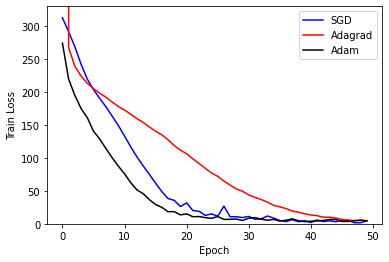

In [ ]:
result_save_path = f'/content/drive/My Drive/MIE424Project/Results'
sgd = np.loadtxt(f"{result_save_path}/SGD_lr0.1train_loss.txt")
adagrad = np.loadtxt(f"{result_save_path}/Adagrad_lr0.01train_loss.txt")
adam = np.loadtxt(f"{result_save_path}/Adam_lr1e-4train_loss.txt")

x = np.arange(50)
plt.plot(x, sgd, "-b", label="SGD")
plt.plot(x, adagrad, "-r", label="Adagrad")
plt.plot(x, adam, "-k", label="Adam")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
ax = plt.gca()
ax.set_ylim([0, 330])
plt.legend()
plt.show()

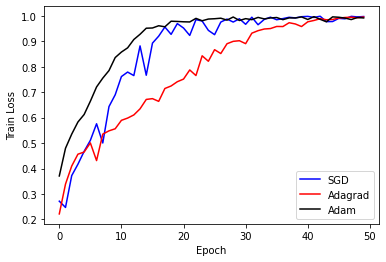

In [ ]:
result_save_path = f'/content/drive/My Drive/MIE424Project/Results'
sgd = np.loadtxt(f"{result_save_path}/SGD_lr0.1train_acc.txt")
adagrad = np.loadtxt(f"{result_save_path}/Adagrad_lr0.01train_acc.txt")
adam = np.loadtxt(f"{result_save_path}/Adam_lr1e-4train_acc.txt")

x = np.arange(50)
plt.plot(x, sgd, "-b", label="SGD")
plt.plot(x, adagrad, "-r", label="Adagrad")
plt.plot(x, adam, "-k", label="Adam")
plt.xlabel("Epoch")
plt.ylabel("Train Accuracy")
plt.legend()
plt.show()

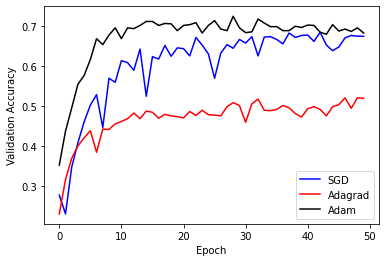

In [ ]:
result_save_path = f'/content/drive/My Drive/MIE424Project/Results'
sgd = np.loadtxt(f"{result_save_path}/SGD_lr0.1val_acc.txt")
adagrad = np.loadtxt(f"{result_save_path}/Adagrad_lr0.01val_acc.txt")
adam = np.loadtxt(f"{result_save_path}/Adam_lr1e-4val_acc.txt")

x = np.arange(50)
plt.plot(x, sgd, "-b", label="SGD")
plt.plot(x, adagrad, "-r", label="Adagrad")
plt.plot(x, adam, "-k", label="Adam")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()
